### Imports and setup

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pyreadr
import seaborn as sns
import statsmodels.formula.api as smf
from psmpy import PsmPy

pd.set_option("display.max_columns", None)

In [2]:
PATH = "lalonde.RData"
seed = 1234
num_trees = None

Y = "re78"
treat = "treat"
covar = [
    "age",
    "education",
    "black",
    "hispanic",
    "married",
    "nodegree",
    "re74",
    "re75",
    "u74",
    "u75",
]

raw = pyreadr.read_r(PATH)

___
## LDW-Experimental

Dehejia and Wahba argue the refined dataset, LaLonde-Dehejia-Wahba (LDW) data, is a valid experimental sample.

In [3]:
data = raw["ldw"].copy().reset_index(drop=True)
data.reset_index(inplace=True, names="row_idx")

In [4]:
data.groupby(treat)["sample"].count()

treat
0.0    260
1.0    185
Name: sample, dtype: int64

### Covariate balance

In [5]:
data[data[treat] == 0][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.053846,7.057745,17.0,19.00,24.0,28.000000,55.000000
education,10.088462,1.614325,3.0,9.00,10.0,11.000000,14.000000
black,0.826923,0.379043,0.0,1.00,1.0,1.000000,1.000000
hispanic,0.107692,0.310589,0.0,0.00,0.0,0.000000,1.000000
married,0.153846,0.361497,0.0,0.00,0.0,0.000000,1.000000
nodegree,0.834615,0.372244,0.0,1.00,1.0,1.000000,1.000000
re74,2107.026651,5687.905639,0.0,0.00,0.0,139.424698,39570.679688
re75,1266.909015,3102.982088,0.0,0.00,0.0,650.096451,23031.980469
u74,0.750000,0.433848,0.0,0.75,1.0,1.000000,1.000000
u75,0.684615,0.465565,0.0,0.00,1.0,1.000000,1.000000


In [6]:
data[data[treat] == 1][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


___

**Theorem [Rosenbaum-Rubin].** 

Under the assumptions presented in the theoretical part, the following holds ${Y(0), Y(1)} \perp D | p(X).$ Here, $p(X) := P(D=1 | X)$ is the
so-called propensity score.

___

### Positivity check

c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


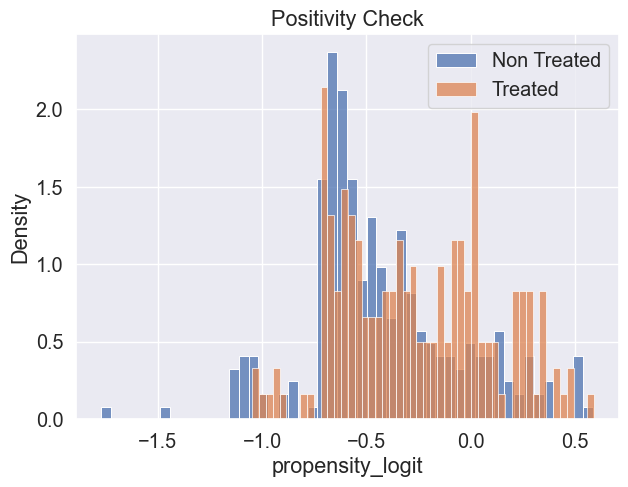

In [7]:
psm = PsmPy(data, treatment=treat, indx="row_idx", exclude=["data_id", Y, "sample"])
psm.logistic_ps(balance=False)

plt.figure(figsize=(7, 5))
sns.histplot(
    psm.predicted_data.query("treat==0")["propensity_logit"],
    kde=False,
    label="Non Treated",
    bins=50,
    stat="density",
)
sns.histplot(
    psm.predicted_data.query("treat==1")["propensity_logit"],
    kde=False,
    label="Treated",
    bins=50,
    stat="density",
)
plt.title("Positivity Check")
plt.legend();

### ATE

In [8]:
data.query("treat==1")[Y].mean() - data.query("treat==0")[Y].mean()

1794.3423818501024

### Estimation via linear regression

In [11]:
lr = smf.ols("re78 ~ treat", data=data).fit()

lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4554.8011,408.046,11.162,0.000,3752.855,5356.747
treat,1794.3424,632.853,2.835,0.005,550.574,3038.110
